**TL;DR:** Initial full attempt resulted in only ~0.5 accuracy on full sample; clearly something is off. Speculated that this was due to the truncated vocabulary used still being too large, and/or not lemmatising, resulting in an inadequate (noisy and/or lossy) word2vec representation. Haven't finished testing this idea yet.

In [1]:
import math as m
import numpy as np
import pandas as pd
import re
from scipy import stats
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
import tensorflow.keras.callbacks as callbacks
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
import word2vec
# from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
DATA_DIR = '/workspace/data/sentiment_analysis'
CHKPT_DIR = f'{DATA_DIR}/checkpoints'
LOG_DIR = f'{DATA_DIR}/logs'

# Load & prep data

In [4]:
tweets = pd.read_csv(f'{DATA_DIR}/training.1600000.processed.noemoticon.csv',
                     header=None, encoding='ISO-8859-1')

In [5]:
tweets.shape

(1600000, 6)

In [6]:
SAMPLE_SIZE = tweets.shape[0]

In [7]:
tweets.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
tweets[0].value_counts()

0    800000
4    800000
Name: 0, dtype: int64

In [9]:
tweets.rename(columns = { 0: 'positive', 5: 'tweet' }, inplace=True)
tweets = tweets[['positive', 'tweet']]
tweets['positive'] = (tweets.positive == 4).astype(np.bool)

## Identify number of terms (size of vocabulary) to consider
using IDF (inverse document frequency) distribution

In [10]:
vectoriser = TfidfVectorizer()
doc_terms = vectoriser.fit_transform(tweets.tweet)

In [11]:
stats.describe(vectoriser.idf_)

DescribeResult(nobs=684358, minmax=(2.250207176415574, 14.59236763164987), mean=14.211100645629408, variance=0.7161283022424955, skewness=-3.981211810930763, kurtosis=22.023923629571634)

/root/custom-miniconda/miniconda/envs/custom_python38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

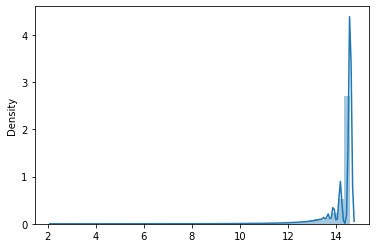

In [12]:
sns.distplot(vectoriser.idf_)

In [13]:
vectoriser.idf_

array([ 8.26621816,  8.40513073, 13.6760769 , ..., 14.59236763,
       13.6760769 , 14.59236763])

#### Find a threshold at which to exclude terms

In [14]:
np.median(vectoriser.idf_)

14.59236763164987

The median is equal to the maximum

In [15]:
np.percentile(vectoriser.idf_, 10)

13.3396046631545

In [16]:
np.percentile(vectoriser.idf_, 12)

13.676076899775714

In [17]:
pctl15 = np.percentile(vectoriser.idf_, 15)

In [18]:
m.exp(14.59236763164987)

2174626.8219081517

In [19]:
m.exp(np.percentile(vectoriser.idf_, 12))

869850.7287632598

In [20]:
m.exp(pctl15)

1087313.4109540756

In [21]:
vectoriser.idf_[vectoriser.idf_ < pctl15].shape

(102552,)

The 15th percentile looks like a fine threshold

## word2vec training

### Tokenise (and reassemble) Tweets to include only 200,000 most frequent terms

This is clearly clunky, but it's the best I can do with Tokenizer's current interface

In [22]:
tokeniser = Tokenizer(num_words=vectoriser.idf_[vectoriser.idf_ < pctl15].shape[0])
tokeniser.fit_on_texts(tweets.tweet)
tweets.tweet = tokeniser.sequences_to_texts(tokeniser.texts_to_sequences(tweets.tweet))

In [23]:
rep_word = r'\b(\w+?)\s+\1(\s+\1)+'
repl = r'\1 \1'
tweets['tweet'] = tweets.tweet.apply(lambda s: re.sub(rep_word, repl, s))

In [24]:
rep_char = r'(\w)\1(\1)+'
repl = r'\1\1'
tweets['tweet'] = tweets.tweet.apply(lambda s: re.sub(rep_char, repl, s))

In [25]:
# pathological corner case(s)
ugh = r'\s+([^\s]+?)\s+\1(\s+\1)+'
repl = r' \1 \1'
tweets['tweet'] = tweets.tweet.apply(lambda s: re.sub(ugh, repl, s))

In [26]:
tweets.to_csv(f'{DATA_DIR}/training.1600000.cleaned.csv', index=False)

### Write vocabulary into file compatible with word2vec input format

In [27]:
vocab_file = f'{DATA_DIR}/tweet_vocab_200000.txt'

In [27]:
f = open(vocab_file, 'w')
f.write(tweets.tweet.str.cat(sep=' '))
f.close()

### Train using vocabulary file and write results

In [28]:
vocab_vectors_file = f'{DATA_DIR}/tweet_vocab_200000_vectors.bin'

In [29]:
word2vec.word2vec(vocab_file, vocab_vectors_file)

### Create lists of vectors for Tweets

In [29]:
word2vec_model = word2vec.load(vocab_vectors_file)

In [30]:
def get_vector(t):
    if t in word2vec_model:
        return word2vec_model[t]
    return []

In [31]:
def words2vecs(w):
    return list(map(lambda t: get_vector(t), w))

tweets['vectors'] = tweets.tweet.str.split().apply(lambda words: words2vecs(words))
tweets['vectors'] = tweets.vectors.apply(lambda vecs: np.array([v for v in vecs if len(v) > 0]))

#### Pad list of vectors for each Tweet

In [33]:
!touch $f'{DATA_DIR}/tweet_vectors.npy'

In [35]:
MAXWIDTH = tweets.vectors.apply(lambda vecs: len(vecs)).max()

In [36]:
DTYPE = np.float64
DTYPE_BYTES = 8
BATCHSIZE = 1000
VECDIM = 100

In [36]:
for i in range(1600):
    print(f'writing batch {i}')
    mmap_tmp = np.memmap(f'{DATA_DIR}/tweet_vectors.npy', dtype=DTYPE, mode='r+',
                         shape=(BATCHSIZE, MAXWIDTH, VECDIM),
                         offset = i * BATCHSIZE * MAXWIDTH * VECDIM * DTYPE_BYTES)
    mmap_tmp[:] = sequence.pad_sequences(tweets.vectors[(i*BATCHSIZE):((i+1)*BATCHSIZE)], 
                                         dtype=DTYPE, maxlen=MAXWIDTH, padding='post')
    mmap_tmp.flush()

writing batch 0
writing batch 1
writing batch 2
writing batch 3
writing batch 4
writing batch 5
writing batch 6
writing batch 7
writing batch 8
writing batch 9
writing batch 10
writing batch 11
writing batch 12
writing batch 13
writing batch 14
writing batch 15
writing batch 16
writing batch 17
writing batch 18
writing batch 19
writing batch 20
writing batch 21
writing batch 22
writing batch 23
writing batch 24
writing batch 25
writing batch 26
writing batch 27
writing batch 28
writing batch 29
writing batch 30
writing batch 31
writing batch 32
writing batch 33
writing batch 34
writing batch 35
writing batch 36
writing batch 37
writing batch 38
writing batch 39
writing batch 40
writing batch 41
writing batch 42
writing batch 43
writing batch 44
writing batch 45
writing batch 46
writing batch 47
writing batch 48
writing batch 49
writing batch 50
writing batch 51
writing batch 52
writing batch 53
writing batch 54
writing batch 55
writing batch 56
writing batch 57
writing batch 58
writing

writing batch 462
writing batch 463
writing batch 464
writing batch 465
writing batch 466
writing batch 467
writing batch 468
writing batch 469
writing batch 470
writing batch 471
writing batch 472
writing batch 473
writing batch 474
writing batch 475
writing batch 476
writing batch 477
writing batch 478
writing batch 479
writing batch 480
writing batch 481
writing batch 482
writing batch 483
writing batch 484
writing batch 485
writing batch 486
writing batch 487
writing batch 488
writing batch 489
writing batch 490
writing batch 491
writing batch 492
writing batch 493
writing batch 494
writing batch 495
writing batch 496
writing batch 497
writing batch 498
writing batch 499
writing batch 500
writing batch 501
writing batch 502
writing batch 503
writing batch 504
writing batch 505
writing batch 506
writing batch 507
writing batch 508
writing batch 509
writing batch 510
writing batch 511
writing batch 512
writing batch 513
writing batch 514
writing batch 515
writing batch 516
writing ba

writing batch 919
writing batch 920
writing batch 921
writing batch 922
writing batch 923
writing batch 924
writing batch 925
writing batch 926
writing batch 927
writing batch 928
writing batch 929
writing batch 930
writing batch 931
writing batch 932
writing batch 933
writing batch 934
writing batch 935
writing batch 936
writing batch 937
writing batch 938
writing batch 939
writing batch 940
writing batch 941
writing batch 942
writing batch 943
writing batch 944
writing batch 945
writing batch 946
writing batch 947
writing batch 948
writing batch 949
writing batch 950
writing batch 951
writing batch 952
writing batch 953
writing batch 954
writing batch 955
writing batch 956
writing batch 957
writing batch 958
writing batch 959
writing batch 960
writing batch 961
writing batch 962
writing batch 963
writing batch 964
writing batch 965
writing batch 966
writing batch 967
writing batch 968
writing batch 969
writing batch 970
writing batch 971
writing batch 972
writing batch 973
writing ba

writing batch 1355
writing batch 1356
writing batch 1357
writing batch 1358
writing batch 1359
writing batch 1360
writing batch 1361
writing batch 1362
writing batch 1363
writing batch 1364
writing batch 1365
writing batch 1366
writing batch 1367
writing batch 1368
writing batch 1369
writing batch 1370
writing batch 1371
writing batch 1372
writing batch 1373
writing batch 1374
writing batch 1375
writing batch 1376
writing batch 1377
writing batch 1378
writing batch 1379
writing batch 1380
writing batch 1381
writing batch 1382
writing batch 1383
writing batch 1384
writing batch 1385
writing batch 1386
writing batch 1387
writing batch 1388
writing batch 1389
writing batch 1390
writing batch 1391
writing batch 1392
writing batch 1393
writing batch 1394
writing batch 1395
writing batch 1396
writing batch 1397
writing batch 1398
writing batch 1399
writing batch 1400
writing batch 1401
writing batch 1402
writing batch 1403
writing batch 1404
writing batch 1405
writing batch 1406
writing batc

#### Free up memory

In [32]:
tweets.drop(columns=['tweet'], inplace=True)

## Build and train a neural network

### Sanity check tools

In [ ]:
incl_vert_batches = Dataset.from_tensor_slices(incl_verts_for_reg).batch(BATCH_SIZE).prefetch(BATCH_SIZE)
img_batches = Dataset.from_tensor_slices(img_vals).batch(BATCH_SIZE).prefetch(BATCH_SIZE)

In [ ]:
def predict_and_write(batches, model, vert_count, frames_npy):
    for i, batch in batches.enumerate().as_numpy_iterator():
        batch_size = batch.shape[0]
        batch_offset = i * BATCH_SIZE
        output_shape = (batch_size, vert_count, VERTEX_DIM)
        pred_positions = model.predict(batch).reshape(output_shape)
        output_frames = np.memmap(frames_npy, dtype=DTYPE, mode='r+', shape = output_shape,
                                  offset = batch_offset * vert_count * VERTEX_DIM * DTYPE_BYTES)
        output_frames[:] = pred_positions
        output_frames.flush()

In [ ]:
def print_summary(vals, vals_label):
    print(f'{vals_label}: mean = {vals.mean()}, var = {vals.var()}, min = {vals.min()}, ' +
          f'median = {np.median(vals)}, max = {vals.max()}')

### Hyperparameter tuning under time constraints: based on data subsample
I know this isn't kosher, but I have a deadline, and hopefully it works well enough for my present purposes?

#### Select random subsample for "cross-validation"
I tried to sample random indices at one go, then select the indexed observations, but my kernel kept dying. Iterating over smaller chunks then aggregating the results seems to be more manageable.

In [13]:
tuning_train_x_chunks, tuning_train_y_chunks = [], []
increment, iter_n = 200000, 8000
for i in range(8):
    start = i * increment
    tuning_train_idx = np.random.randint(start, start + increment, size=iter_n)
    tuning_train_x_chunks.append(padded_vectors[tuning_train_idx])
    y = tweets.positive.iloc[tuning_train_idx].values
    tuning_train_y_chunks.append(np.reshape(y, (y.shape[0], -1)))
tuning_train_x = np.vstack(tuple(tuning_train_x_chunks))
tuning_train_y = np.vstack(tuple(tuning_train_y_chunks))

In [14]:
del tuning_train_x_chunks, tuning_train_y_chunks

In [15]:
tuning_shuffled_idxs = np.arange(tuning_train_x.shape[0])
np.random.shuffle(tuning_shuffled_idxs)
tuning_train_x = tuning_train_x[tuning_shuffled_idxs]
tuning_train_y = tuning_train_y[tuning_shuffled_idxs]

#### Function definitions

In [32]:
def get_model(lstm_units, lstm_do, lstm_recurr_do, dense_units, dense_activ, dense_do, opt):
    #strategy = tf.distribute.MirroredStrategy()
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=False, dropout=lstm_do, recurrent_dropout=lstm_recurr_do))
    model.add(Dense(dense_units, activation=dense_activ))
    model.add(Dropout(dense_do))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
def partition_indices(i, k, index):
    if i < 1 or i > k:
        raise ValueError
    step, n = 1.0 / k, len(index)
    lb, ub = round((i-1) * step * n), round(i * step * n)
    include = list(range(lb))
    include.extend(range(ub, n)) 
    exclude = list(range(lb, ub))
    return index[exclude], index[include]

In [19]:
## Not really k-fold CV, since the model isn't reinstantiated (i.e. weights are carried over from previous
## fold trainings), but c.f. time constraints
# def k_fold_cv(x, y, k, model, cv_verbose=False, **kwargs):
#     accuracy = np.zeros(k)
#     stdevs = np.zeros(k)
#     for i in range(1, k+1):
#         if cv_verbose:
#             print('fold ', i)
#         exclude, include = partition_indices(i, k, np.arange(x.shape[0]))
#         x_fit = x[include]
#         model.fit(x_fit, y[include], **kwargs)
#         exclude_len = len(x[exclude])
#         predictions = np.round(model.predict(x[exclude]))
#         corrects = (predictions == y[exclude]).astype(int)
#         accuracy[i-1] = corrects.mean()
#         stdevs[i-1] = corrects.std()
#     return accuracy, stdevs

In [18]:
def k_fold_cv_iter(x, y, i, k, model, cv_verbose=False, **kwargs):
    exclude, include = partition_indices(i, k, np.arange(x.shape[0]))
    x_fit = x[include]
    model.fit(x_fit, y[include], **kwargs)
    exclude_len = len(x[exclude])
    predictions = np.round(model.predict(x[exclude]))
    return (predictions == y[exclude]).astype(int).mean()

#### Generate train-val-test indices, load data memmap, and pipeline definition

In [37]:
rng = np.random.default_rng(12)
TRAINVAL_IDXS = rng.choice(SAMPLE_SIZE, size=int(0.85*SAMPLE_SIZE), replace=False, shuffle=False)
VAL_IDXS = rng.choice(TRAINVAL_IDXS, size=int(0.15*SAMPLE_SIZE), replace=False, shuffle=False)
TRAIN_IDXS = np.setdiff1d(TRAINVAL_IDXS, VAL_IDXS)
TEST_IDXS = np.setdiff1d(np.arange(SAMPLE_SIZE), TRAINVAL_IDXS)
TRAINVAL_IDXS.sort()
TRAIN_IDXS.sort()
VAL_IDXS.sort()
TEST_IDXS.sort()

In [38]:
padded_vectors = np.memmap(f'{DATA_DIR}/tweet_vectors.npy', dtype=DTYPE, mode='r',
                           shape=(SAMPLE_SIZE, MAXWIDTH, VECDIM))

In [39]:
BATCH_SIZE = 64

In [ ]:
TRAIN_TUPLES = (padded_vectors[TRAIN_IDXS], tweets.positive[TRAIN_IDXS])
train_tuples = Dataset.from_tensor_slices(TRAIN_TUPLES).shuffle(len(TRAIN_IDXS))
train_batches = train_tuples.batch(BATCH_SIZE).prefetch(BATCH_SIZE)

#### First pass

In [ ]:
model = get_model(128, 0.1, 0.1, 32, 'relu', 0.5, 'RMSprop')
model_chkpt = callbacks.ModelCheckpoint(f'{CHKPT_DIR}/pass1', monitor='val_loss', save_best_only=True)
csv_logger = callbacks.CSVLogger(f'{LOG_DIR}/pass1.csv', append=True),
history = model.fit(padded_vectors[TRAIN_IDXS], tweets.positive[TRAIN_IDXS], epochs=10, batch_size=64,
                    validation_data=padded_vectors[VAL_IDXS], callbacks=[model_chkpt, csv_logger])
predictions = model.predict(padded_vectors[TEST_IDXS])
predictions_rd = np.round(predictions)

In [ ]:
accuracies = np.zeros(5)
for i in range(1, 6):
    print('fold ', i)
    accuracies[i-1] = k_fold_cv_iter(tuning_train_x, tuning_train_y, i, 5,
                                     get_model(128, 0.1, 0.1, 32, 'relu', 0.5, 'RMSprop'), epochs=3, batch_size=1600)

In [19]:
accuracies = np.zeros(5)
for i in range(1, 6):
    print('fold ', i)
    accuracies[i-1] = k_fold_cv_iter(tuning_train_x, tuning_train_y, i, 5,
                                     get_model(128, 0.1, 0.1, 32, 'relu', 0.5, 'RMSprop'), epochs=3, batch_size=1600)

fold  1
Train on 51200 samples
Epoch 1/3
51200/51200 [==============================] - 60s 1ms/sample - loss: 5.9437e-08 - accuracy: 0.4938
Epoch 2/3
51200/51200 [==============================] - 57s 1ms/sample - loss: 5.9437e-08 - accuracy: 0.4946
Epoch 3/3
51200/51200 [==============================] - 57s 1ms/sample - loss: 5.9437e-08 - accuracy: 0.4937
fold  2
Train on 51200 samples
Epoch 1/3
51200/51200 [==============================] - 60s 1ms/sample - loss: 5.9621e-08 - accuracy: 0.4947
Epoch 2/3
51200/51200 [==============================] - 56s 1ms/sample - loss: 5.9621e-08 - accuracy: 0.4967
Epoch 3/3
51200/51200 [==============================] - 57s 1ms/sample - loss: 5.9621e-08 - accuracy: 0.4928
fold  3
Train on 51200 samples
Epoch 1/3
51200/51200 [==============================] - 61s 1ms/sample - loss: 5.9719e-08 - accuracy: 0.5048
Epoch 2/3
51200/51200 [==============================] - 57s 1ms/sample - loss: 5.9719e-08 - accuracy: 0.5024
Epoch 3/3
51200/51200 [====

In [21]:
accuracies

array([0.50976562, 0.49148437, 0.51351563, 0.5146875 , 0.5190625 ])

In [20]:
accuracies = np.zeros(5)
for i in range(1, 6):
    print('fold ', i)
    accuracies[i-1] = k_fold_cv_iter(tuning_train_x, tuning_train_y, i, 5,
                                     get_model(128, 0.1, 0.1, 64, 'relu', 0.5, 'RMSprop'), epochs=3, batch_size=1600)

fold  1
Train on 51200 samples
Epoch 1/3
51200/51200 [==============================] - 74s 1ms/sample - loss: 5.9535e-08 - accuracy: 0.5137
Epoch 2/3
51200/51200 [==============================] - 61s 1ms/sample - loss: 5.9535e-08 - accuracy: 0.5108
Epoch 3/3
51200/51200 [==============================] - 59s 1ms/sample - loss: 5.9535e-08 - accuracy: 0.5116
fold  2
Train on 51200 samples
Epoch 1/3
51200/51200 [==============================] - 61s 1ms/sample - loss: 5.9626e-08 - accuracy: 0.5096
Epoch 2/3
51200/51200 [==============================] - 58s 1ms/sample - loss: 5.9626e-08 - accuracy: 0.5101
Epoch 3/3
51200/51200 [==============================] - 58s 1ms/sample - loss: 5.9626e-08 - accuracy: 0.5105
fold  3
Train on 51200 samples
Epoch 1/3
51200/51200 [==============================] - 63s 1ms/sample - loss: 5.9728e-08 - accuracy: 0.5025
Epoch 2/3
51200/51200 [==============================] - 57s 1ms/sample - loss: 5.9728e-08 - accuracy: 0.5000
Epoch 3/3
51200/51200 [====

### Checkpoint 13/6/2020: Maybe that subsampling idea was dumb? I've spent much of my time trying to get the kernel not to die, and gotten not much farther from where I started. 

## UNDER CONSTRUCTION

In [21]:
accuracies

array([0.53523438, 0.50351563, 0.50929687, 0.52984375, 0.45015625])

In [ ]:
accuracies = np.zeros(5)
for i in range(1, 6):
    print('fold ', i)
    accuracies[i-1] = k_fold_cv_iter(tuning_train_x, tuning_train_y, i, 5,
                                     get_model(128, 0.1, 0.1, 32, 'relu', 0.2, 'RMSprop'),
                                     epochs=3, batch_size=1600, workers=8, use_multiprocessing=True)

fold  1
Train on 51200 samples
Epoch 1/3
51200/51200 [==============================] - 66s 1ms/sample - loss: 5.9535e-08 - accuracy: 0.5163
Epoch 2/3
51200/51200 [==============================] - 59s 1ms/sample - loss: 5.9535e-08 - accuracy: 0.5185
Epoch 3/3
51200/51200 [==============================] - 58s 1ms/sample - loss: 5.9535e-08 - accuracy: 0.5183
fold  2
Train on 51200 samples
Epoch 1/3
51200/51200 [==============================] - 63s 1ms/sample - loss: 5.9626e-08 - accuracy: 0.4826
Epoch 2/3
51200/51200 [==============================] - 57s 1ms/sample - loss: 5.9626e-08 - accuracy: 0.4824
Epoch 3/3
51200/51200 [==============================] - 57s 1ms/sample - loss: 5.9626e-08 - accuracy: 0.4837
fold  3
Train on 51200 samples
Epoch 1/3
51200/51200 [==============================] - 64s 1ms/sample - loss: 5.9728e-08 - accuracy: 0.4907
Epoch 2/3
51200/51200 [==============================] - 59s 1ms/sample - loss: 5.9728e-08 - accuracy: 0.4903
Epoch 3/3
51200/51200 [====

In [ ]:
accuracies

#### LSTM (64, 0.1, 0.1), dense (64, 0.5)

adadelta: 0.4037, 0.4049, 0.4066, 0.35

RMSprop: 0.4469, 0.4444, 0.4479, 0.34

#### LSTM (128, 0.1), dense (32, 0.5)

RMSprop: 0.4952, 0.5015, 0.4979, 0.46